# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1001]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import DBSCAN
from queue import Queue

In [2]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [3]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [1002]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        trees = []
        y_new = self._fit_predict_tree(x, y)
        trees.append(self.tree)
        
        error = self.error 
        
        for i in range(self.n_estimators - 1):
            y_new = self._fit_predict_tree(x, error)
            error = self.error
            
            trees.append(self.tree)
        
        self.trees = trees

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        self.tree = DecisionTreeRegressor(max_depth = self.max_depth)
        self.tree.fit(x, y)
        
        self.gamma = 1
        self.error = y - self.gamma * self.learning_rate * self.tree.predict(x)
        
        return self.gamma * self.learning_rate * self.tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна

        y_pred = np.array([self.learning_rate]*len(self.trees)) @ np.array([tree.predict(X_test) for tree in self.trees])
        
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [1003]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [1004]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

ну вот ниже ячейку явно не запускать лучше

In [131]:
np.random.seed(19052019)

estimators = [30, 40, 50, 100, 150, 175, 200, 250, 300, 350, 400, 500]
depths = range(2, 30)
rates = [0.05, 0.1, 0.15, 0.2, 0.22, 0.25]

dt = GradientBoosting(n_estimators=estimators[0], max_depth=depths[0], learning_rate = rates[0])
dt.fit(X_train, y_train)

mse_dict = {}
mse_dict['mse'] = mean_squared_error(y_test, dt.predict(X_test))
mse_dict['learning_rate'] = rates[0]
mse_dict['n_estimators'] = estimators[0]
mse_dict['max_depth'] = depths[0]


for n in estimators[1:]:   
    for depth in depths[1:]:
        for rate in rates[1:]:
            np.random.seed(19052019)
            dt = GradientBoosting(n_estimators=n, max_depth=depth, learning_rate = rate)
            dt.fit(X_train, y_train)
            if mean_squared_error(y_test, dt.predict(X_test)) < mse_dict['mse']:
                mse_dict['mse'] = mean_squared_error(y_test, dt.predict(X_test))
                mse_dict['learning_rate'] = rate
                mse_dict['n_estimators'] = n
                mse_dict['max_depth'] = depth


mse_dict

{'mse': 9.619440927625302,
 'learning_rate': 0.22,
 'n_estimators': 500,
 'max_depth': 6}

In [1005]:
np.random.seed(19052019)

gb = GradientBoosting(500, 6, 0.22)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

In [1006]:
mean_squared_error(y_test, y_pred)

9.619440927625302

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да / **Нет**

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [1007]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [1008]:
train.head()

Month DayofMonth DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0   c-8       c-21       c-7     1934            AA    ATL  DFW       732   
1   c-4       c-20       c-3     1548            US    PIT  MCO       834   
2   c-9        c-2       c-5     1422            XE    RDU  CLE       416   
3  c-11       c-25       c-6     1015            OO    DEN  MEM       872   
4  c-10        c-7       c-6     1828            WN    MDW  OMA       423   

  dep_delayed_15min  
0                 N  
1                 N  
2                 N  
3                 N  
4                 Y

In [1009]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state = 12)

xgb = XGBClassifier()
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.7053973161832912

Ну выбросим прямо очевидные ошибки

In [1010]:
train = train[train['DepTime'] < 2359]

И используем всеееее

In [1011]:
X_train = train.drop('dep_delayed_15min', axis=1).values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state = 12)

cat_ind = np.where(train.dtypes != 'int64')[0][:-1]

In [1012]:
cat = CatBoostClassifier(silent=True)
cat.fit(X_train_part, y_train_part, cat_features = cat_ind)
roc_auc_score(y_valid, cat.predict_proba(X_valid)[:, 1])

0.7627270371518274

ну вот и все - видимо ненужных данных не бывает

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [695]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [999]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples

        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        
        #пусть cначала все шумовые
 



    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query())
        q = Queue()
        cluster = [root]
        
        self.labels[root] = 0

        
    

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        return self.X[dist(self.X, x) <= self.eps]

    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        return np.sqrt(np.sum((a-b) ** 2, axis = 1))
        

Проверим себя на простом примере:

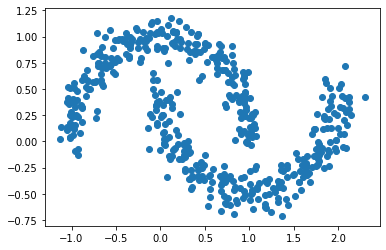

In [914]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

Референс:

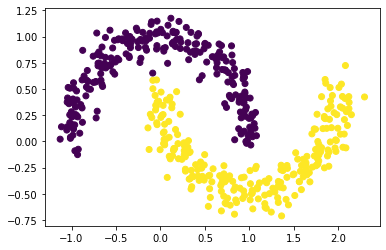

In [917]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



In [ ]:
# your code here


Или хотя бы что-нибудь такое: 

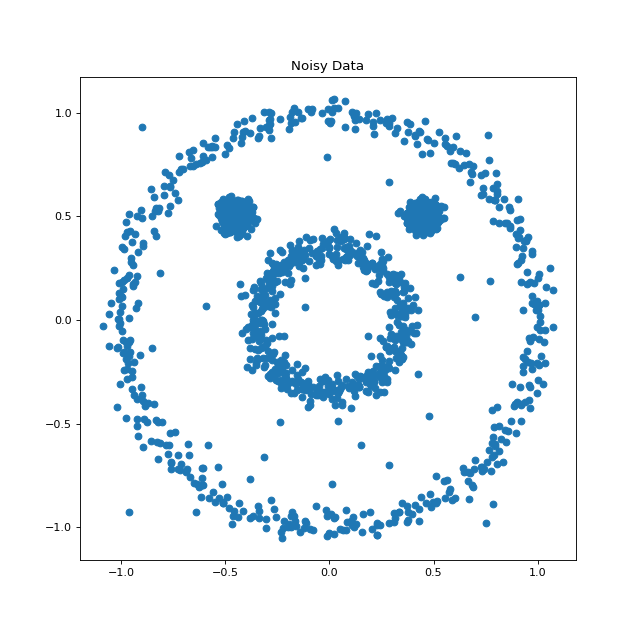

In [ ]:
# your code here



> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [921]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 6.23 ms, sys: 4.59 ms, total: 10.8 ms
Wall time: 12.9 ms


In [922]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 119 ms, sys: 2.55 ms, total: 122 ms
Wall time: 136 ms


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

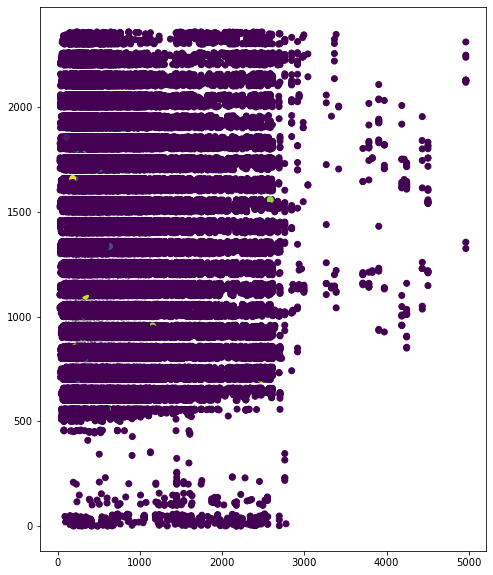

In [1018]:
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state = 222)


dbscan = DBSCAN()
cluster = dbscan.fit_predict(X_train)

plt.figure(figsize= (8,10))
plt.scatter(X_train[:, 0], X_train[:,1], c = cluster)
plt.show()

In [406]:
pd.DataFrame(cluster).value_counts().sort_values()

 107        5
 53         5
 54         5
 55         5
 57         5
        ...  
 18         8
 56         8
 99         8
 88        10
-1      99300
Length: 127, dtype: int64

In [1014]:
len(np.unique(cluster))

127

Вышло 127 кластеров, но только 700 из 100000 не попали в нойз

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ При малеком e шумовых точек очень много, так как размерности у переменных очень большие. Размер сэмпла тут как будто бы не очень играет роль, шумовые точки определяются в основном e

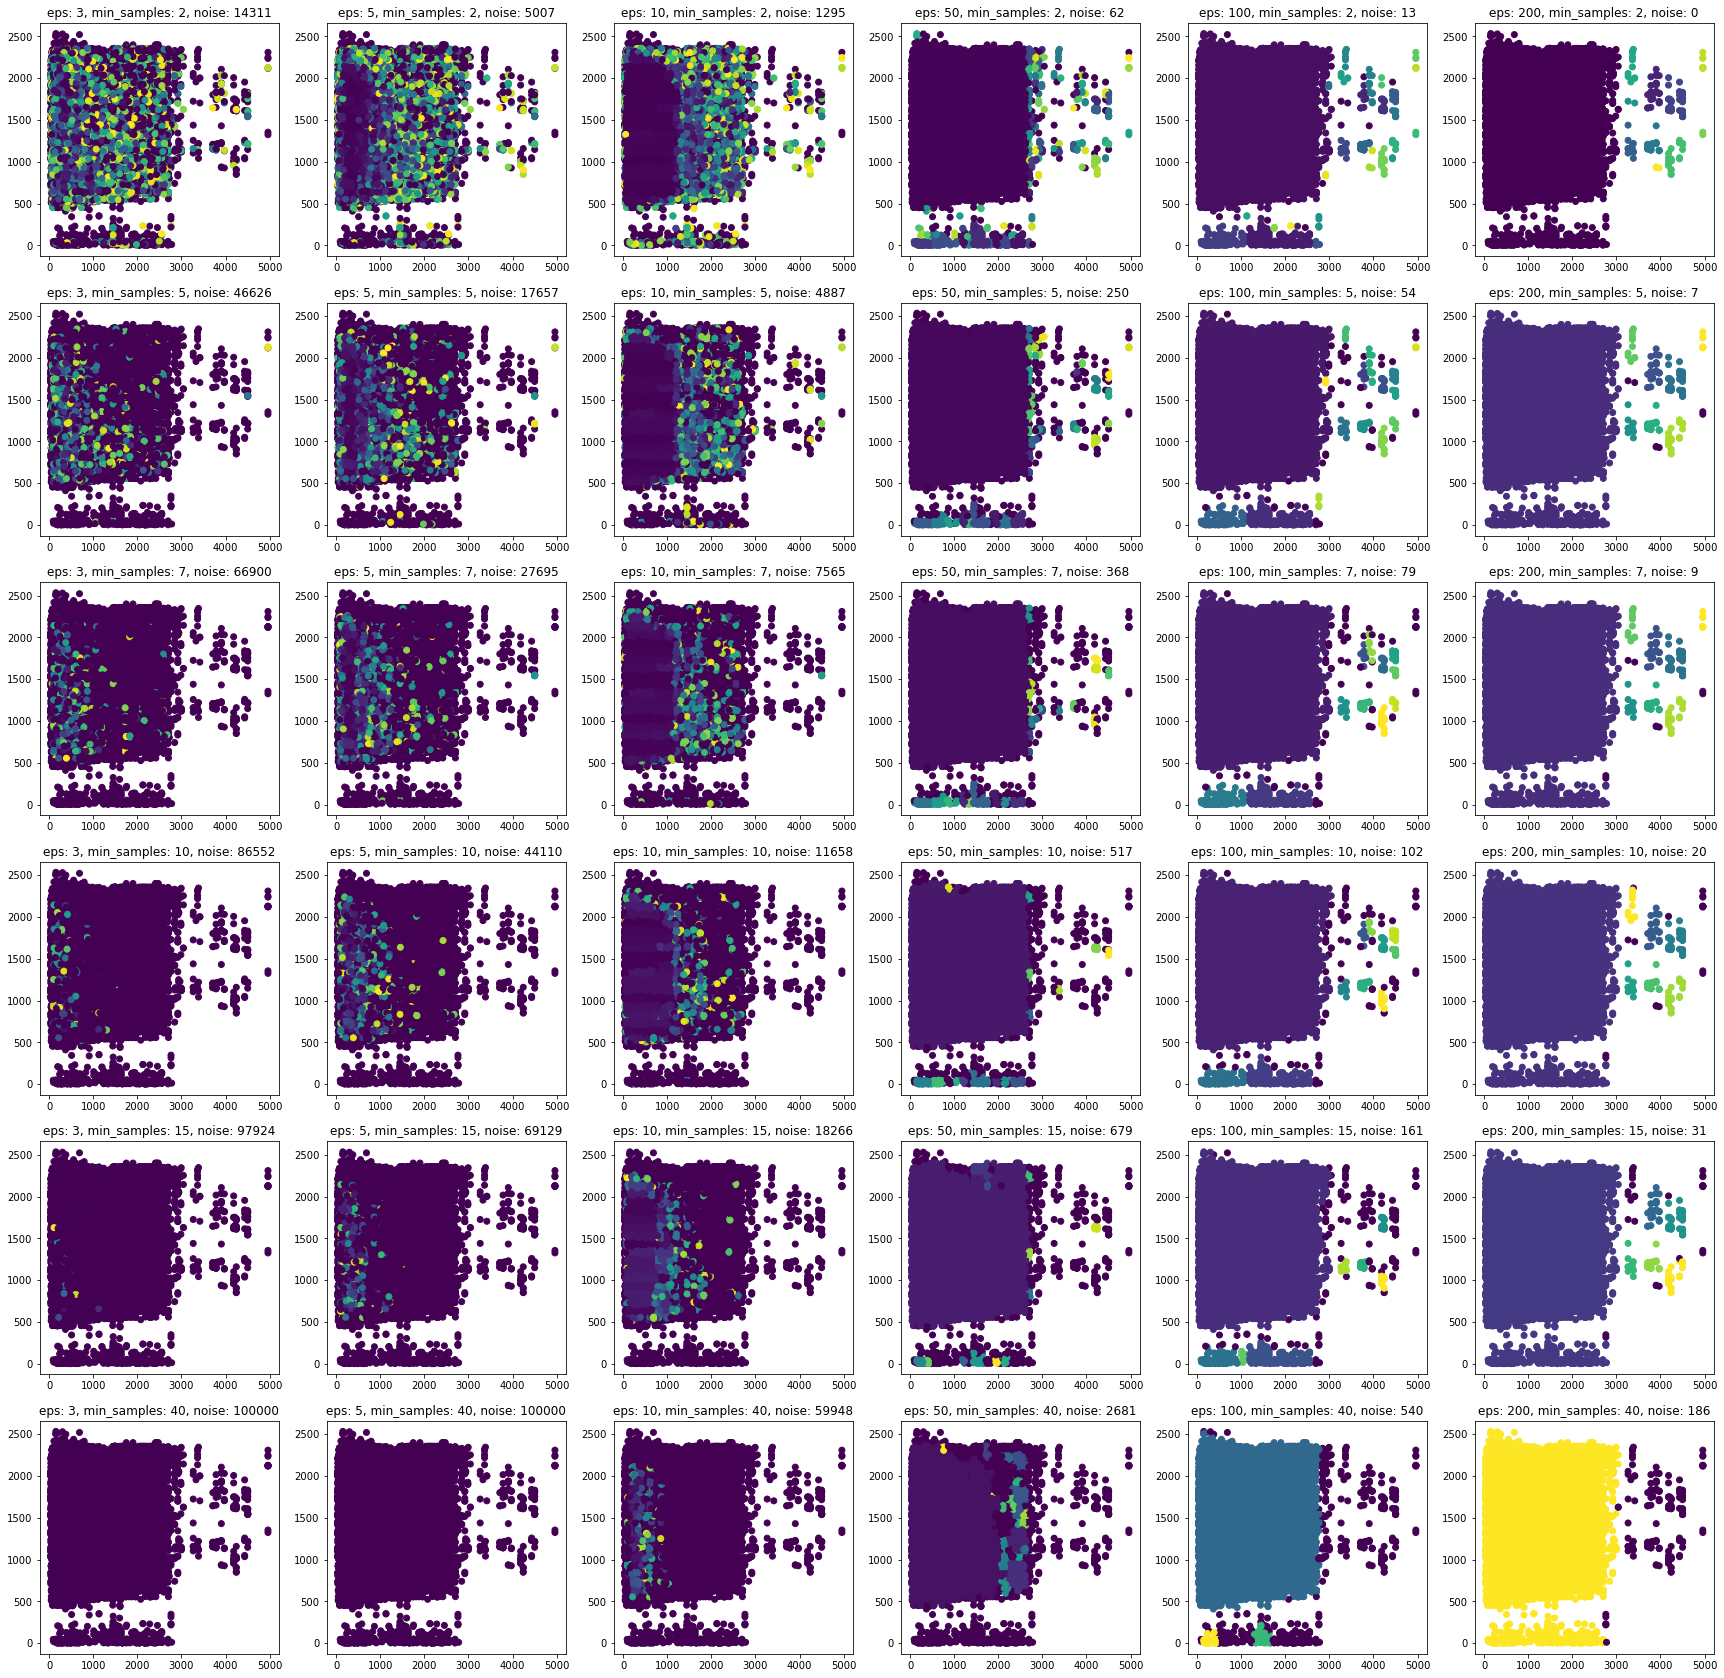

In [414]:
fig, axs = plt.subplots(6, 6, figsize=(30,30))
samples = [2, 5, 7, 10, 15, 40]
e = [3, 5, 10, 50, 100, 200]

for i in range(len(samples)):
    for q in range(len(e)):
        dbscan = DBSCAN(eps=e[q], min_samples=samples[i])
        clusters = dbscan.fit_predict(X_train)
        noise = abs(sum(clusters[clusters == -1]))
        axs[i, q].scatter(X_train[:, 0], X_train[:,1], c = clusters)
        axs[i, q].set_title(f"eps: {e[q]}, min_samples: {samples[i]}, noise: {noise}")

plt.show()

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

я выбирала по адекватности и небольшому количеству нойза

In [1019]:
dbscan = DBSCAN(eps=100, min_samples=10)
clusters = dbscan.fit_predict(X_train)

In [1021]:
len(np.unique(clusters)), pd.DataFrame(clusters).value_counts().sort_values()

(12,
  9        10
  2        11
  7        12
  8        12
  4        16
  10       16
  6        19
  5        22
 -1       101
  3       138
  1       257
  0     99344
 dtype: int64)

In [1024]:
X_train_new = np.vstack([X_train[:, 0], X_train[:, 1], clusters]).T
X_train_new

array([[ 732, 1934,    0],
       [ 834, 1548,    0],
       [ 416, 1422,    0],
       ...,
       [1076, 1901,    0],
       [ 140, 1515,    0],
       [ 605, 1800,    0]])

In [1025]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train_new, y_train, test_size=0.3, random_state = 12)

In [1026]:
cat = CatBoostClassifier(silent=True)
cat.fit(X_train_part, y_train_part, cat_features=[2])
roc_auc_score(y_valid, cat.predict_proba(X_valid)[:, 1])

0.707236225019422

__Ответ:__ выросло на 0.002))) совсем незначительно - при том, что референсным был xgboost, можно сказать, что ничего просто не изменилось

странно было предполагать, что время отправления и время полета могут выступать основаниями для кластеризации, то есть по этим признакам самолеты могут как-то группироваться в кластеры, было видно на картинках и по количеству нойза, а также по наполненности кластеров, что это очень странное предположение, поэтому и на модель оно особо не повлияло

Кроме того, само по cебе разбиение на кластеры вышло не очень - хоть кластеров и относительно немного, они не равнонаполены, сильный перевес нулевого

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

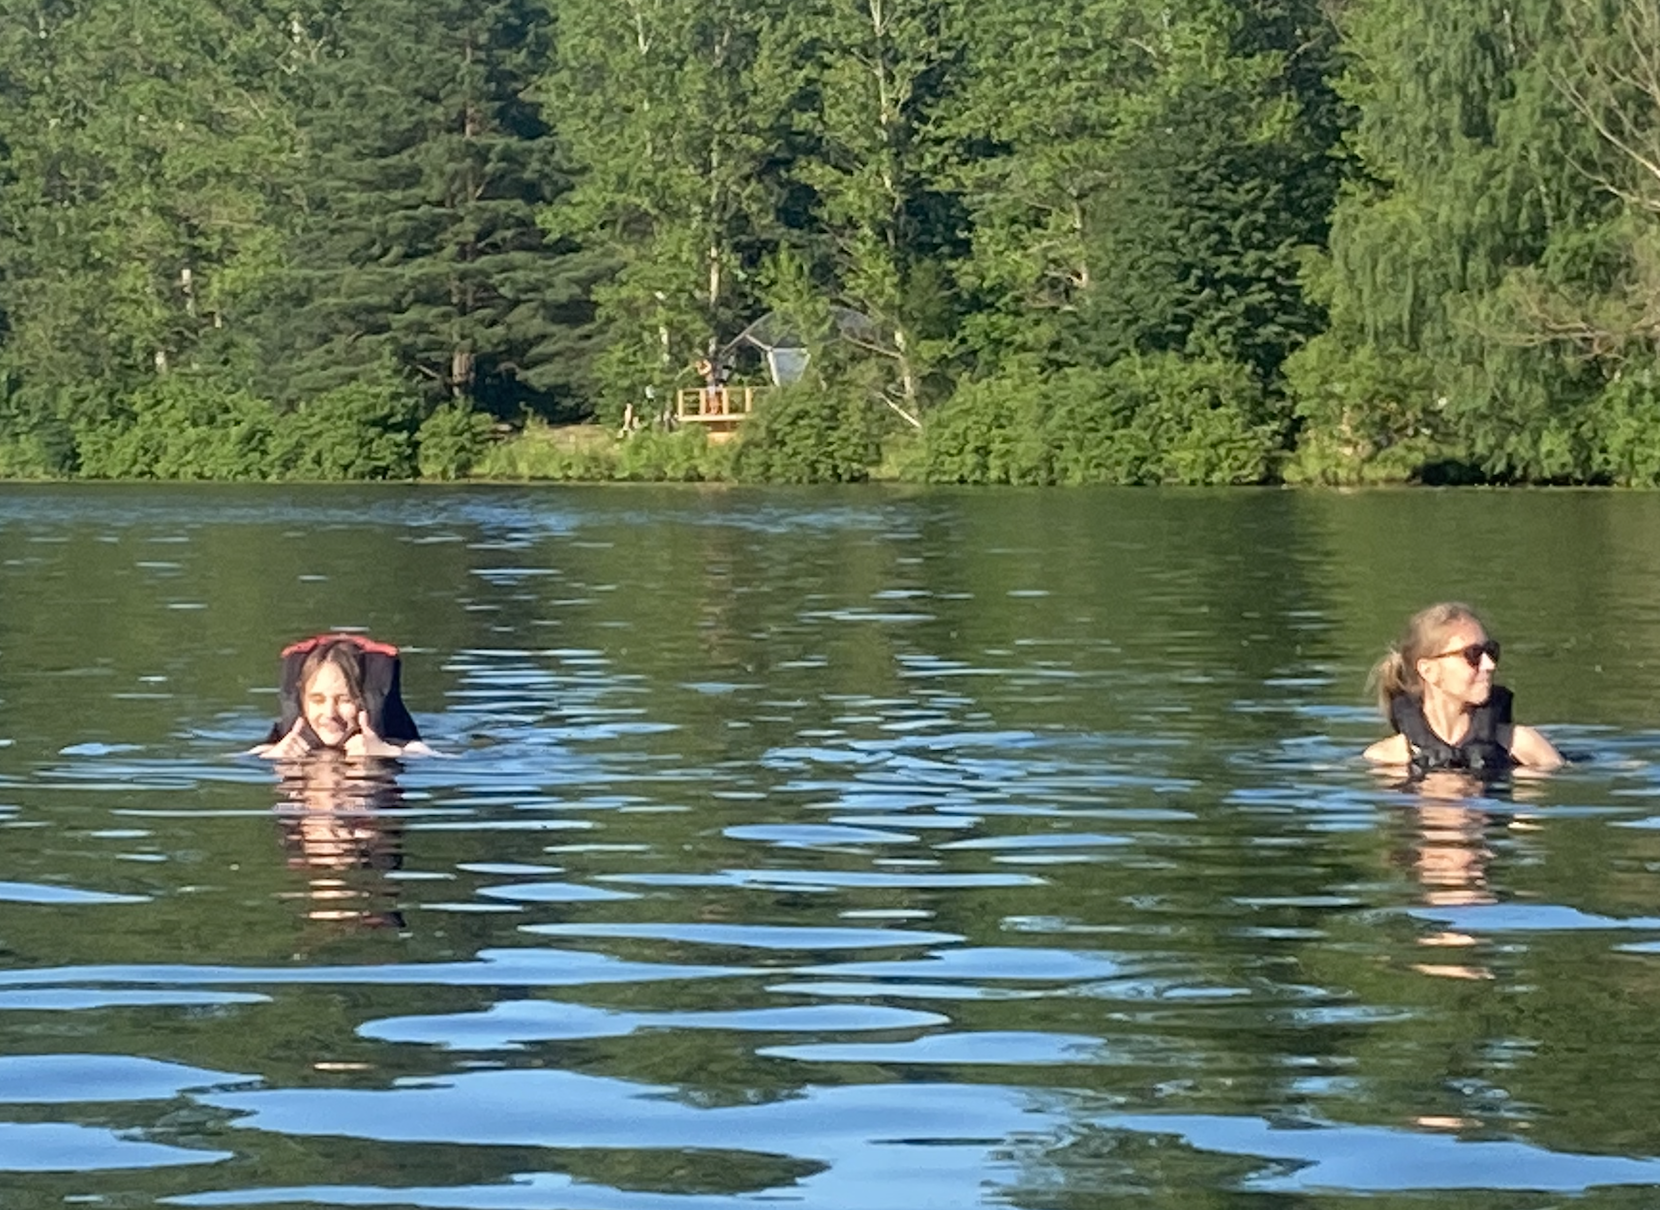

In [923]:
from IPython.display import Image
Image('leto.png', width=500)

**+0.1 балла** за смешной мем по машинному обучению

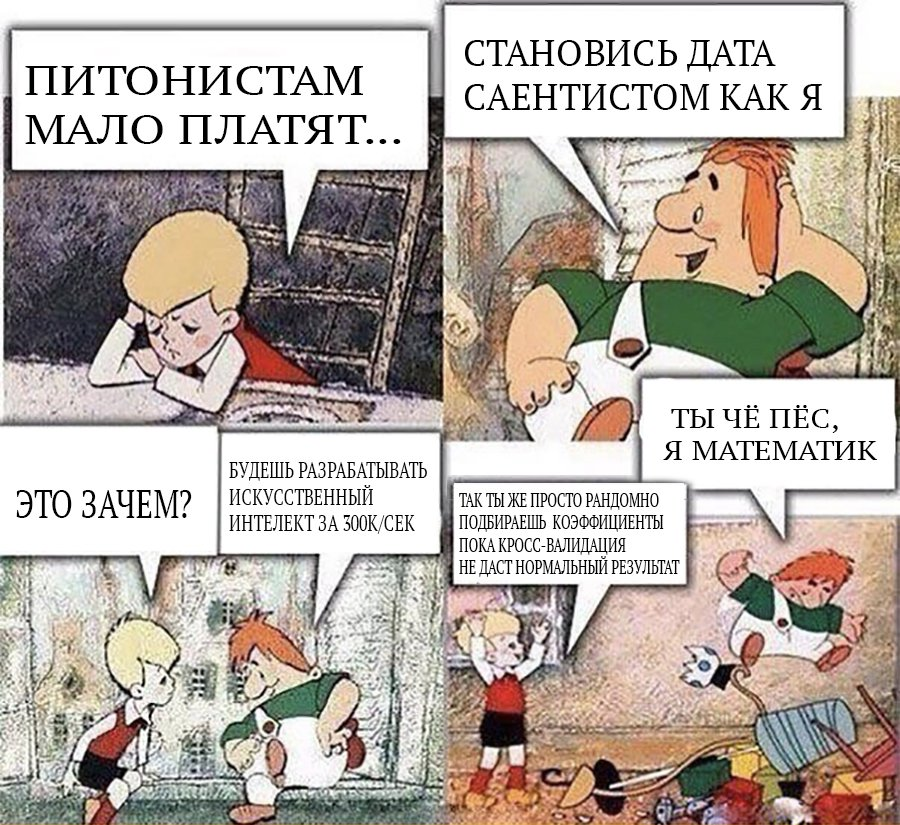

In [924]:
Image('meme.jpeg', width=500)

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.

Самый лучший курс на моем втором курсе (даже лучше макры) - самым сложным было уметь делать все - углубляться в теорию на лекциях, дальше сразу свитчиться на практические семинары и пытаться отказываться от циклов. Было бы очень круто, если бы на иаде было 2 потока, на одном из которых давали бы материал на уровне МО-1, а на другом как есть. Потому что по итогам курса очень хочется взять МО-1, но это кажется странным, так как темы дублируются, но погружения в теорию хочется на уровне МО-1 